In [2]:
import numpy as np
from fetch_data import get_data, remove_cols
from helper import *
from getters_alpaca import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import requests

In [6]:
coin_name = "LTCUSDT"
interval = "15m"
limit: int = 2000

from fetch_data import get_data, remove_cols
# get alpaca data
binance_data = get_data(coin_name, interval, limit)
binance_data = remove_cols(binance_data, "close_time", "quote_asset_volume", "number_of_trades", "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume")

# turn it to np
binance_data = np.array(binance_data)

start time: 2024-05-13 03:30:17


In [3]:
# fetch once and save it so we don't need to do it again thus saving a lot of time
# without it we would need to fetch all the candles againg which would take a several minutes with high limit number
display_data_to_file(binance_data, "alpaca_data")

If data are loaded in csv start from here ↓

In [31]:
# load
binance_data = load_data_from_file("alpaca_data")

In [32]:
# make series with usefull data
data = fill_data(binance_data)
#display_data_to_file(data, "working_data")
m, n = data.shape
np.random.shuffle(data)

In [33]:
data_train = data[:int(0.8*m)]
y_train = torch.tensor(data_train[:,0], dtype=torch.float32)
x_train = torch.tensor(data_train[:, 1:], dtype=torch.float32)

data_test = data[int(0.8*m):m]
y_test = torch.tensor(data_test[:,0], dtype=torch.float32)
x_test = torch.tensor(data_test[:, 1:], dtype=torch.float32)

In [34]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_features=12, l1 = 10, l2=10):
        super().__init__()
        # nn.Parameter is a tensor with bunus features that it becomes connected to model and is updated during training by optimizer
        self.weights1 = nn.Parameter(torch.randn(in_features, l1, dtype=torch.float), requires_grad=True)
        self.bias1 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        
        self.weights2 = nn.Parameter(torch.randn(l1, l2, dtype=torch.float), requires_grad=True)
        self.bias2 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        
        self.weights3 = nn.Parameter(torch.randn(l2, dtype=torch.float), requires_grad=True)
        self.bias3 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
    
        
    def forward(self, x) -> torch.Tensor:
        # print(f'{x.shape} x {self.weights1.size()}')
        x = torch.matmul(x, self.weights1) + self.bias1
        # print(f'{x.shape} x {self.weights2.size()}')
        x = torch.relu(x)
        x = torch.matmul(x, self.weights2) + self.bias2
        # print(f'{x.shape} x {self.weights2.size()}')
        x = torch.relu(x)
        x = torch.matmul(x, self.weights3) + self.bias3
        # print(x.shape)
        return x
    
torch.manual_seed(4)

# I use cpu (default) since i have intel gpu and cuda isn't suppported (only nvidia)
model = NeuralNetwork()

# adjusts waights and losses
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# calculates loss - there are more ways to calculate so there are different ones
loss_fn = nn.L1Loss() 

In [35]:
# best yet result using lr=0.0001 and 20000 epochs - best average loss 3.3, test average loss 3.7 - took 50min
epochs = 2000
losses = []
test_losses = []
for epoch in range(epochs):
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)
    losses.append(torch.mean(loss).detach().numpy())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch == 1000:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0005
            
    if epoch == 1500:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.0001
        
    with torch.inference_mode():
      test_pred = model(x_test)
      test_loss = loss_fn(test_pred, y_test)
      test_losses.append(torch.mean(test_loss).detach().numpy())
      
      # Print the average loss every few epochs
    if (epoch + 1) % 100 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {loss}, Test avg loss: {test_loss}')


Epoch [100/2000], Average Loss: 678.25439453125, Test avg loss: 692.9402465820312
Epoch [200/2000], Average Loss: 367.9364013671875, Test avg loss: 376.6687316894531
Epoch [300/2000], Average Loss: 252.64669799804688, Test avg loss: 260.1891174316406
Epoch [400/2000], Average Loss: 191.42684936523438, Test avg loss: 196.65818786621094
Epoch [500/2000], Average Loss: 145.1893310546875, Test avg loss: 148.703369140625
Epoch [600/2000], Average Loss: 118.19510650634766, Test avg loss: 122.30894470214844
Epoch [700/2000], Average Loss: 112.61518096923828, Test avg loss: 100.60844421386719
Epoch [800/2000], Average Loss: 81.94591522216797, Test avg loss: 78.03003692626953
Epoch [900/2000], Average Loss: 58.16853332519531, Test avg loss: 54.95970916748047
Epoch [1000/2000], Average Loss: 29.3698673248291, Test avg loss: 31.964475631713867
Epoch [1100/2000], Average Loss: 24.47885513305664, Test avg loss: 26.975709915161133
Epoch [1200/2000], Average Loss: 24.59264373779297, Test avg loss: 24

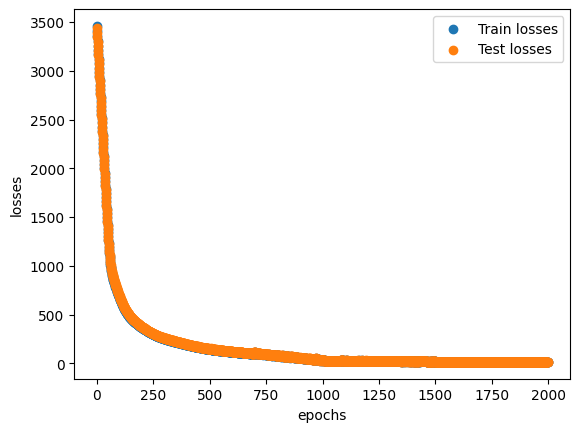

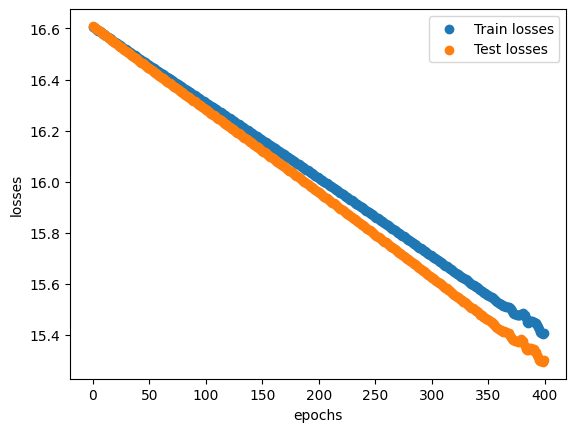

In [36]:
import matplotlib.pyplot as plt
plt.scatter(range(epochs), losses, label='Train losses')
plt.scatter(range(epochs), test_losses, label='Test losses')
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()
plt.show()

split = int(epochs*0.2)

plt.scatter(range(split), losses[-split:], label='Train losses')
plt.scatter(range(split), test_losses[-split:], label='Test losses')
plt.xlabel("epochs")
plt.ylabel("losses")
plt.legend()
plt.show()

In [37]:
with torch.no_grad():  # Disable gradient tracking during inference
    for i, item in enumerate(x_test):
        y_pred = model(item.unsqueeze(0))  # Ensure item has batch dimension
        correct = y_test[i].item()

        print(f'expected: {correct}, guessed: {y_pred.item()}')

expected: -1.059999942779541, guessed: -1.527820348739624
expected: 0.0, guessed: -22.685047149658203
expected: 0.5899999737739563, guessed: 0.32862502336502075
expected: -2.700000047683716, guessed: 0.5907099843025208
expected: 0.10000000149011612, guessed: 25.072277069091797
expected: 0.5899999737739563, guessed: 2.020519495010376
expected: -0.4399999976158142, guessed: -0.29832810163497925
expected: -0.44999998807907104, guessed: 6.094738483428955
expected: 0.699999988079071, guessed: -0.6547734141349792
expected: 0.2199999988079071, guessed: -0.7272831797599792
expected: -0.10000000149011612, guessed: 0.6362422108650208
expected: -0.4699999988079071, guessed: -0.05345505475997925
expected: 0.3799999952316284, guessed: 0.14258986711502075
expected: 0.7300000190734863, guessed: 24.330577850341797
expected: -0.3799999952316284, guessed: 14.004894256591797
expected: 0.2800000011920929, guessed: 0.9956172108650208
expected: 0.30000001192092896, guessed: -0.6525761485099792
expected: 0.1